In [1]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

## Read data into scanpy
* needs to be transposed first to be loaded properly
* load into scanpy object

In [2]:
def transpose_csv(csv_path, output_csv_path='transposed.csv', delimiter=','):
    # code copied from: https://stackoverflow.com/questions/7156539/how-do-i-transpose-pivot-a-csv-file-with-python-without-loading-the-whole-file
    import csv

    transposed_iterator = zip(*csv.reader(open(csv_path)))
    with open(output_csv_path, 'w') as out:
        for row in transposed_iterator:
            out.write(delimiter.join(row) + '\n')

raw_file = "GSE125881_raw.expMatrix.csv"
transposed_file = "expMatrix_transposed.csv"

if not os.path.exists(transposed_file):
    transpose_csv(raw_file, transposed_file)

In [3]:
# we see 62k cells and 20k genes
expr = sc.read_csv(transposed_file, first_column_names=True)
expr

AnnData object with n_obs × n_vars = 62167 × 20223

## Quality Control
* filter cells with < 200 genes
* filter genes with < 3 cells
* filter cells with > 10% mitochodrial genes

In [4]:
expr.var['mt'] = expr.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(expr, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
expr.obs.head()

,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
AAACCTGAGCGTCTAT-1,2500,8780.0,333.0,3.792711
AAACCTGCAATAGAGT-1,2549,8782.0,739.0,8.414940
AAACCTGCATGACGGA-1,3146,10911.0,540.0,4.949134
AAACCTGGTAGTGAAT-1,4310,18042.0,1167.0,6.468241
AAACCTGGTCTCCCTA-1,4628,24558.0,1217.0,4.955615


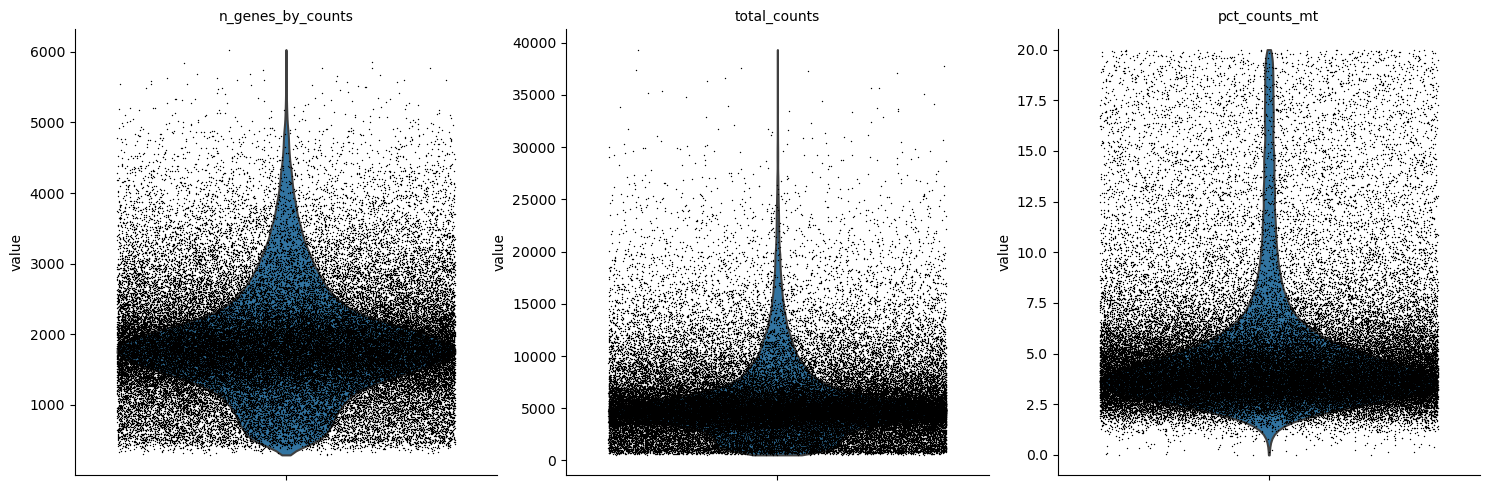

In [5]:
# n_genes_by_counts: Number of genes expressed in each cell (we filter out those with < 200)
# pct_counts_mt: Percentage of reads in each cell that are mitochondrial
# also filter out cells with >10% mitochondrial reads
sc.pp.filter_cells(expr, min_genes=200)
sc.pp.filter_genes(expr, min_cells=3)
sc.pl.violin(expr, ['n_genes_by_counts', 'total_counts', 'n_genes_by_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [6]:
expr = expr[expr.obs.n_genes_by_counts > 200,]
expr = expr[expr.obs.pct_counts_mt < 10,]

## Normalization
* normalize data to log(CPM+1)
* look at highly variable genes
* scale normalize the data

In [7]:
sc.pp.normalize_total(expr)
sc.pp.log1p(expr)
expr.raw = expr 

/Users/elanasimon/miniconda3/envs/bmi2/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [11]:
# notice that most of the high variable genes are TRB genes
sc.pp.highly_variable_genes(expr)
expr.var['trb'] = expr.var_names.str.startswith('TRB')
expr.var.loc[expr.var.highly_variable].sort_values("dispersions", ascending=False).head(10)

,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,trb,highly_variable,means,dispersions,dispersions_norm
S100A9,False,77,0.019689,99.876140,1224.0,77,False,True,0.013921,4.757143,14.140092
TRBV7-2,False,2294,0.481992,96.309939,29964.0,2294,True,True,0.377325,3.484430,8.916879
TRBV10-3,False,1090,0.326942,98.246658,20325.0,1090,True,True,0.281928,3.357422,8.565622
MTRNR2L12,False,58496,8.922001,5.905062,554654.0,58496,False,True,2.325795,3.318659,3.073340
LYZ,False,368,0.034472,99.408046,2143.0,368,False,True,0.022269,3.287997,9.632686
TRBV7-3,False,1243,0.280921,98.000547,17464.0,1243,True,True,0.243818,3.256322,8.286018
TRBV4-1,False,2035,0.489408,96.726559,30425.0,2035,True,True,0.405404,3.205354,8.145060
TRBV11-2,False,2305,0.617900,96.292245,38413.0,2305,True,True,0.462127,3.176631,8.065622
TRBV12-3,False,1589,0.389178,97.443982,24194.0,1589,True,True,0.329502,3.121294,7.912581
TRBV13,False,1036,0.254122,98.333521,15798.0,1036,True,True,0.204568,3.077064,8.985533


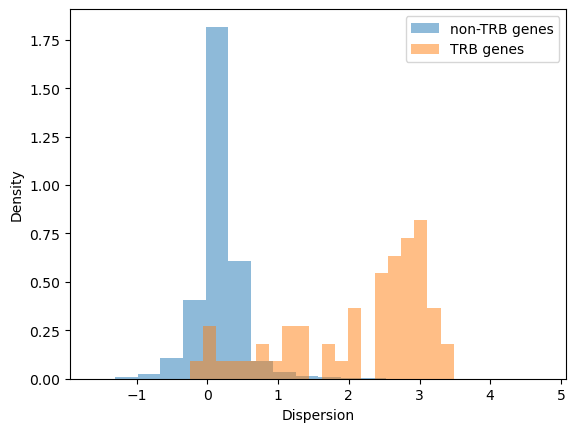

In [28]:
plt.hist(data=expr.var.loc[~expr.var.trb], x="dispersions", label="non-TRB genes", density=True, alpha=0.5, bins=20)
plt.hist(data=expr.var.loc[expr.var.trb], x="dispersions", label="TRB genes", density=True, alpha=0.5, bins=20)
plt.xlabel("Dispersion")
plt.ylabel("Density")
plt.legend()
plt.show()

In [10]:
sc.pp.scale(expr, max_value=10)

# Visualize clusters

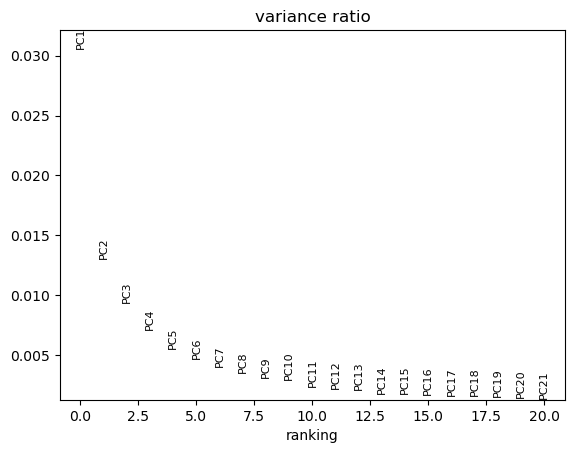

In [11]:
sc.tl.pca(expr)
sc.pl.pca_variance_ratio(expr, n_pcs=20)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/elanasimon/miniconda3/envs/bmi2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


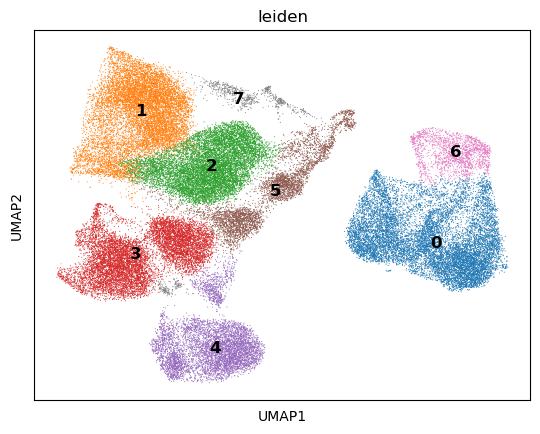

In [12]:
sc.pp.neighbors(expr, n_pcs=15)
sc.tl.leiden(expr, resolution=0.2)
sc.tl.umap(expr)
fig = sc.pl.umap(expr, color=['leiden'],
                legend_fontsize = 12,
                legend_loc = 'on data')

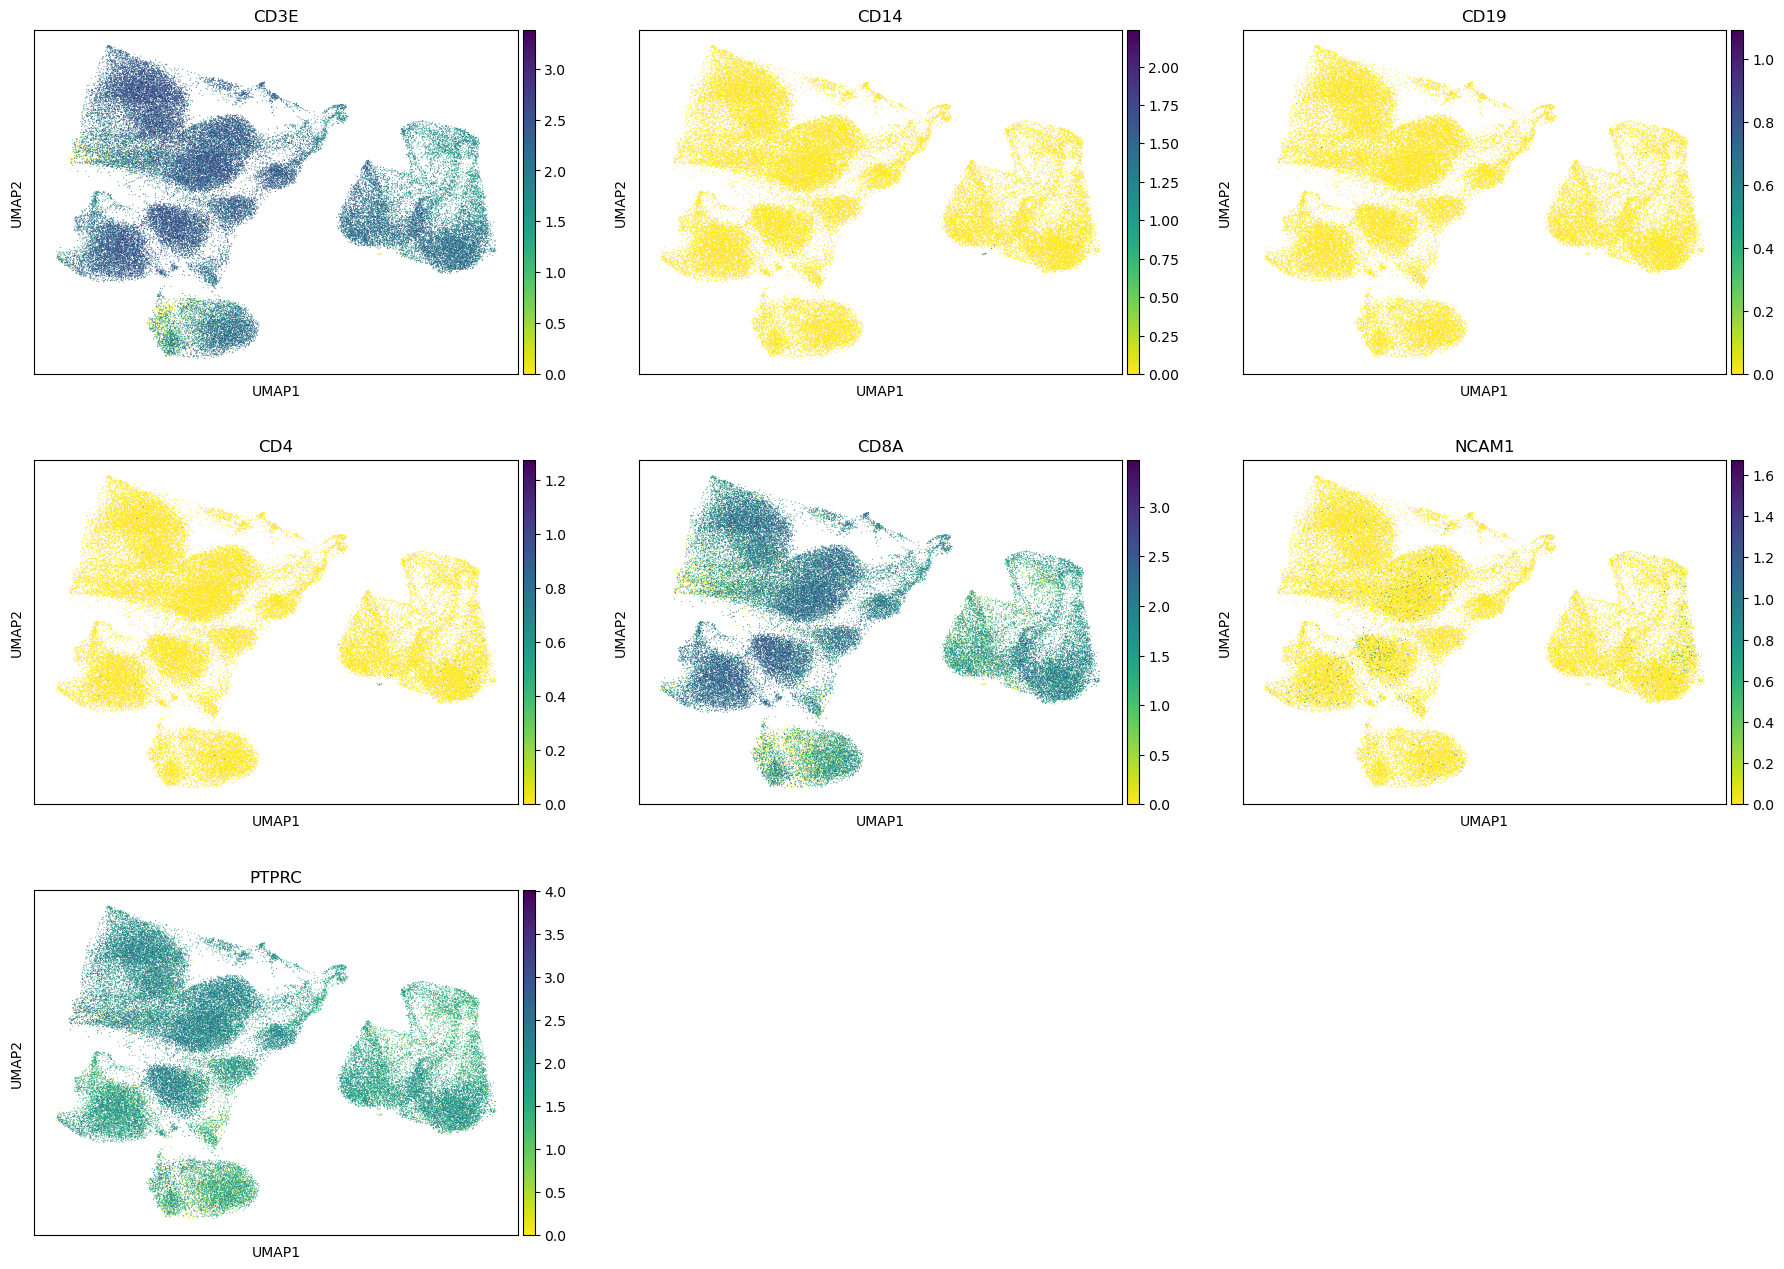

In [32]:
# CD3E: T cells
# CD14: Monocytes
# CD19: B cells
# CD4: Helper T cells
# CD8A: Cytotoxic T cells
# NCAM1: NK cells
# PTPRC: Leukocytes

genes_to_plot = ["CD3E", "CD14", "CD19", "CD4", "CD8A", "NCAM1", "PTPRC"]

sc.pl.umap(expr, color=genes_to_plot, use_raw=True,
                sort_order=True, ncols=3, cmap='viridis_r')



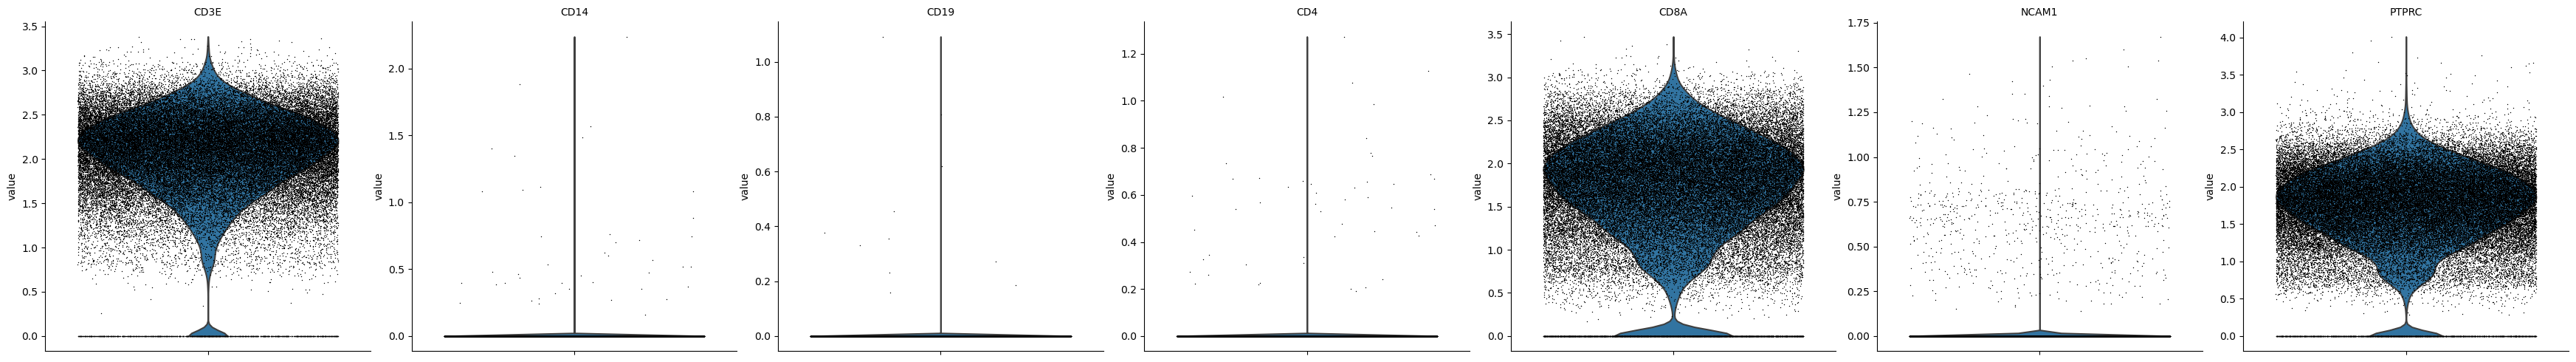

In [33]:
sc.pl.violin(expr, genes_to_plot,
             jitter=0.4, multi_panel=True)

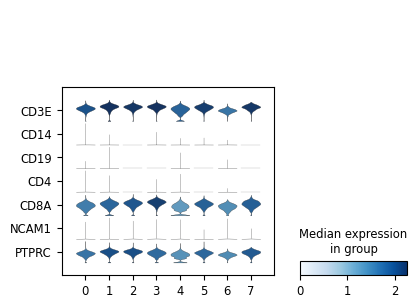

In [34]:
sc.pl.stacked_violin(expr, genes_to_plot, groupby='leiden', swap_axes=True)
plt.show()

# Match barcode data with metadata and visualized based on sample info

In [72]:
meta = pd.read_csv("geo_metadata.csv")
meta.head()
id_to_timepoint_type = dict(zip(meta["id_in_expmatrix"].astype(str), meta["time_point_type"]))
id_to_disease_state = dict(zip(meta["id_in_expmatrix"].astype(str), meta["disease_state"]))

In [73]:
expr.obs["sample_id"] = [barcode.split("-")[-1] for barcode in expr.obs.index]
expr.obs["disease_state"] = expr.obs["sample_id"].map(id_to_disease_state)
expr.obs["time_point_type"] = expr.obs["sample_id"].map(id_to_timepoint_type)

/Users/elanasimon/miniconda3/envs/bmi2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


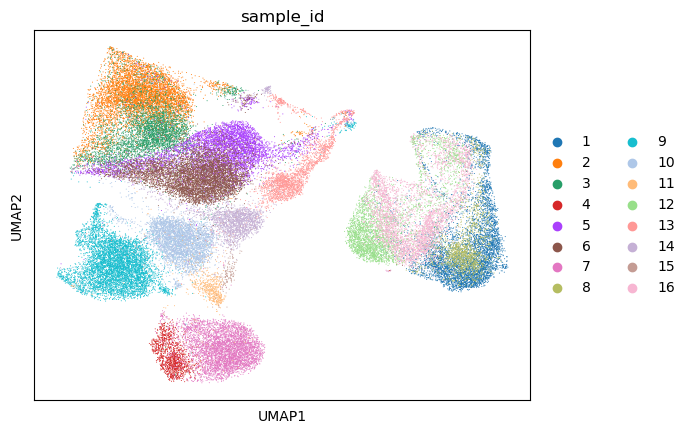

/Users/elanasimon/miniconda3/envs/bmi2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


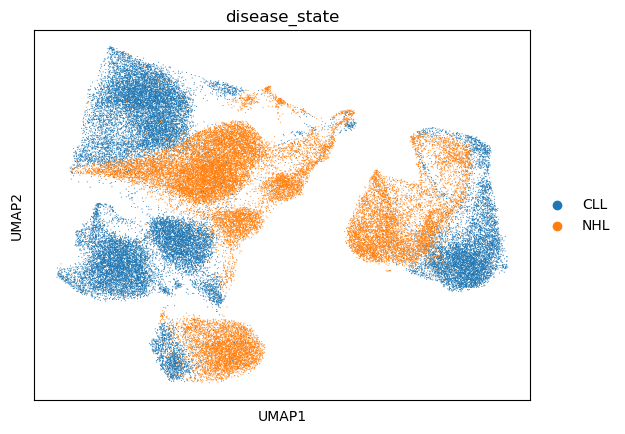

/Users/elanasimon/miniconda3/envs/bmi2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


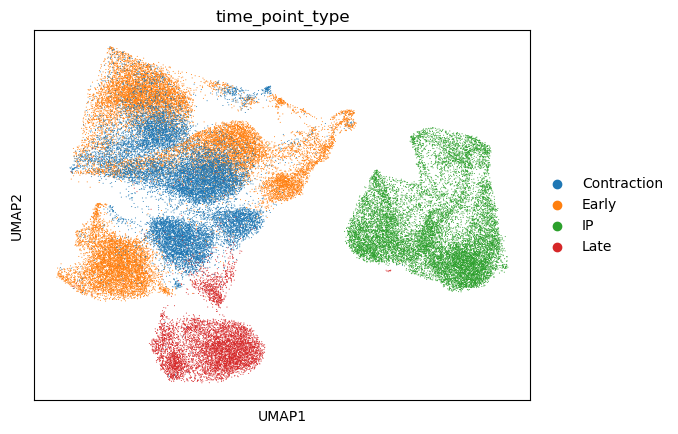

In [76]:
sc.pl.umap(expr, color="sample_id")
sc.pl.umap(expr, color="disease_state")
sc.pl.umap(expr, color="time_point_type")

# TODO NEXT
* for a given patient how does gene expression change over time?
    * compare Early, Contraction, and Late to IP
    * do GSEA btwn E,C,L and IP